In [1]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import netCDF4
import os
import os.path as op
import sys
import metpy
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
import statsmodels.api as sm
import re
import xarray as xr
from itertools import product as iterProduct
%matplotlib inline

In [2]:
def goes_2_roi(loaded_goes, 
               target_extent,
               target_rows,
               target_cols,
               cartopy_target_proj,
               data_key='Rad',
               radius_of_influence=50000):
    """Function that goes from loaded GOES data to data resampled in a projection for an extent"""
    dat = loaded_goes.metpy.parse_cf('Rad')
    #dat = loaded_goes['Rad'].data
    geos_crs = dat.metpy.cartopy_crs
    cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
    pyresample_source_extent = (cartopy_source_extent[0],
                                cartopy_source_extent[2],
                                cartopy_source_extent[1],
                                cartopy_source_extent[3])
    rad = dat.data
    source_area = geometry.AreaDefinition('GOES-1X', 'Full Disk','GOES-1X', 
                                          geos_crs.proj4_params,
                                          rad.shape[1], rad.shape[0],
                                          pyresample_source_extent)
    area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                        cartopy_target_proj.proj4_params,
                                        target_rows, target_cols,
                                        target_extent)
    geos_con_nn = image.ImageContainerNearest(rad, 
                                            source_area, 
                                            radius_of_influence=radius_of_influence)
    lons, lats = area_target_def.get_lonlats()

    # Here we are using pyresample for the remapping
    area_proj_con_nn = geos_con_nn.resample(area_target_def)
    return area_proj_con_nn.image_data, lons, lats
        
def cartopy_pyresample_toggle_extent(input_extent):
    return np.array(input_extent)[np.array([0,2,1,3])]


def trasform_cartopy_extent(source_extent,source_proj, target_proj):
    target_extent = target_proj.transform_points(source_proj, 
                                                 np.array(source_extent[:2]),
                                                 np.array(source_extent[2:])).ravel()
    # target_extent in 3D, must be in 2D
    return cartopy_pyresample_toggle_extent(np.array(target_extent)[np.array([0,1,3,4])])

def normIm(im,gamma=1.0,reverse=False):
    nim = ((im-np.nanmin(im))*(np.nanmax(im)-np.nanmin(im))**(-1))
    if reverse:#want clouds to be white
        nim = (1.0-nim**(gamma))
    return nim

def getPlankConsts(satim):
    """Extract the planck parameters fk1, fk2, bc1 and bc2 for temperature conversion."""
    return {
    'fk1':float(satim['planck_fk1'].data),
    'fk2':float(satim['planck_fk2'].data),
    'bc1':float(satim['planck_bc1'].data),                       
    'bc2':float(satim['planck_bc2'].data)}

def Rad2BT(rad, plancks):
    """Radiances to Brightness Temprature (using black body equation)"""
    # unpack
    fk1, fk2, bc1, bc2 = plancks['fk1'], plancks['fk2'], plancks['bc1'], plancks['bc2']
    invRad = np.array(rad)**(-1)
    arg = (invRad*fk1) + 1.0
    T = (- bc1+(fk2 * (np.log(arg)**(-1))) )*(1/bc2) 
    return T

def convert2intIfPossible(value):
        try:
            if type(1) != type(value):
                value = int(value)
        except:
            pass
        return value

def getMatchesFromFiles(filenames,platform=None, year=None, dayofyear=None, hour=None, minute=None, second=None):
    strPatt = (r'.*OR_ABI-L1b-Rad(?P<product>[CFM])-M6C(?P<band>\d{2})_G(?P<platform>\d{2})_s' + 
        r'(?P<year>\d{4})(?P<dayofyear>\d{3})(?P<hour>\d{2})(?P<minute>\d{2})(?P<seconds>\d{2}).*\.nc')
    patt = re.compile(strPatt)
    kwargs = {'platform':platform, 'year':year,'dayofyear':dayofyear, 'hour':hour, 'minute':minute, 'second':second}
    pairs = [(filename, re.match(patt,filename)) for filename in filenames if re.match(patt,filename)]
    filtered = pairs
    for key, value in kwargs.items():
        value = convert2intIfPossible(value)
        if value:
            filtered = [(filename,match) for filename, match in filtered 
                        if convert2intIfPossible(match.group(key)) == value]
    return filtered

In [ ]:
DATAPATH= './data'

In [ ]:
!ls data

In [ ]:
openDsets = [xr.open_dataset(op.join(DATAPATH,'OR_ABI-L1b-RadF-M6C07_G16_s20191030000200_e20191030009519_c20191030009557.nc')),
             xr.open_dataset(op.join(DATAPATH,'OR_ABI-L1b-RadF-M6C07_G16_s20191030010200_e20191030019520_c20191030019552.nc')),
             xr.open_dataset(op.join(DATAPATH,'OR_ABI-L1b-RadF-M6C07_G17_s20191030000339_e20191030009417_c20191030009441.nc')),
             xr.open_dataset(op.join(DATAPATH,'OR_ABI-L1b-RadF-M6C07_G17_s20191030010339_e20191030019416_c20191030019440.nc'))]

In [ ]:
fname = op.join('./data/OR_ABI-L1b-RadF-M6C07_G16_s20191030000200_e20191030009519_c20191030009557.nc')
print(fname)
xrry = xr.open_dataset(str(fname))
dat = xrry.metpy.parse_cf('Rad')

In [ ]:
pc = ccrs.PlateCarree()
mc = ccrs.Mercator()

# Convert extent from pc to mc (both cylindrical projections)
extent_pc = [-109.59326, -102.40674, 8.94659, -8.94656]


In [ ]:
target_extent_mc_cartopy = trasform_cartopy_extent(extent_pc, pc, mc)
target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)
print('target_extent_mc_pyresample',target_extent_mc_pyresample)
print('target_extent_mc_cartopy',target_extent_mc_cartopy)

In [ ]:
roi_rads_array = [goes_2_roi(openDset,
                   target_extent_mc_pyresample,
                   2001,
                   401,
                   mc) for openDset in openDsets]

In [ ]:
fig = plt.figure(figsize=(15, 8))

for i in range(1,5):
    ax_1 = fig.add_subplot(1, 4, i, projection=mc)
    ax_1.set_extent(target_extent_mc_cartopy, crs=mc)
    ax_1.imshow(normIm(roi_rads_array[i-1][0],gamma=1.0,reverse=True), origin='upper',
               extent=target_extent_mc_cartopy,
               transform=mc,
               interpolation='none')
    if i in [1,2]:
        ax_1.set_title('GOES-16', loc='left', fontweight='bold')
    else:
        ax_1.set_title('GOES-17', loc='left', fontweight='bold')

In [ ]:
time = [openDset.t.data for openDset in openDsets[:2]]
time

In [ ]:
lons = roi_rads_array[0][1][:,0]
lons.shape

In [ ]:
lats = roi_rads_array[0][2][0,:]
lats.shape

In [ ]:
platform = [16,17]

In [ ]:
len(roi_rads_array)

In [ ]:
print(len(roi_rads_array[:2]))
print(roi_rads_array[:2])

In [ ]:
npdata = np.stack([np.dstack([mat[0] for mat in roi_rads_array[:2]]),
                                     np.dstack([mat[0] for mat in roi_rads_array[2:]])], axis=-1)

In [ ]:
npdata.shape

In [ ]:
oddata = xr.DataArray(data=npdata, 
                      coords={'x':lats, 'y':lons, 'time':time,'platform':platform}, 
                      dims=['y','x','time','platform'])

In [ ]:
with open('./rclone_granules.txt', 'r') as fid:
    text = fid.read()
lines = text.split('\n')    

In [ ]:
lines[0]

In [ ]:
str_patt = (r'.*OR_ABI-L1b-Rad(?P<product>[CFM])-M6C(?P<band>\d{2})_G(?P<platform>\d{2})_s' + 
        r'(?P<year>\d{4})(?P<dayofyear>\d{3})(?P<hour>\d{2})(?P<minute>\d{2})(?P<seconds>\d{2}).*\.nc')
print(str_patt)
patt = re.compile(str_patt)

In [ ]:
m = re.match(patt,lines[0])
print(m)
if m:
    print(m.group('product'))
    print(m.group('band'))
    print(m.group('platform'))
    print(m.group('year'))  
    print(m.group('dayofyear'))
    print(m.group('hour'))
    print(m.group('minute'))
    print(m.group('seconds'))

In [ ]:
platform, band, dayofyear, hour = 16, 8, 240, 99

mlines = ([line for line in text.split('\n') if ( (re.match(patt,line)) and
                                             (int(re.match(patt,line).group('platform')) == platform) and
                                             (int(re.match(patt,line).group('band')) == band) and
                                             (int(re.match(patt,line).group('dayofyear')) == dayofyear) and
                                             (int(re.match(patt,line).group('hour')) < hour))])

print(len(mlines))
print(mlines)
len(lines)

In [ ]:
print([line for line in text.split('\n') if ((re.match(patt,line)) and
                                             (re.match(patt,line).group('hour') == '00')  and
                                             (int(re.match(patt,line).group('minute')) < 30)  and
                                             (int(re.match(patt,line).group('dayofyear')) == 240) and
                                             (int(re.match(patt,line).group('platform'))== 16))])

In [ ]:
DIRLIST = os.listdir('./data')
# print(getMatchesFromFiles(dirlist))
# print('\n'.join(dirlist))
filelist = sorted(getMatchesFromFiles(DIRLIST, platform=16, year=2019, dayofyear=240))
#print(filelist)
print('\n'.join([fname for fname, m in filelist]))

In [13]:
def processFilesToROI(platforms,
                      years,
                      bands,
                      daysofyear,
                      ROI,
                      indatapath,
                      outputpath,
                      abiproduct='F',
                      target_proj = ccrs.Mercator()):
    
    # Reference projection for lon-lat
    pc = ccrs.PlateCarree()
    target_extent_mc_cartopy = trasform_cartopy_extent(ROI['extent'], pc, target_proj)
    target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)
    
    
    roidays = iterProduct(platforms, years, bands, daysofyear)
    # for attributes get list of files
    for attriblist in roidays:
        platform, year, band, dayofyear = attriblist
        dirlist = os.listdir(indatapath)
        # if not empty
        filelist = sorted(getMatchesFromFiles(dirlist, platform=platform, year=year, dayofyear=dayofyear))
        if filelist:
            filelist = filelist[:2]
            # Go through load each file
            openDsets = [xr.open_dataset(op.join(indatapath, fname[0])) for fname in  filelist]
            # Do ROI conversions for each loaded file
            roi_rads_array = [goes_2_roi(openDset,
                   target_extent_mc_pyresample,
                   ROI['north_south_px'],
                   ROI['east_west_px'],
                   target_proj) for openDset in openDsets]
            _, lat, lon = roi_rads_array[0]
            npdata = np.stack([roi_rad_array[0] for roi_rad_array in roi_rads_array],axis=-1)
            times = [openDset.t.data for openDset in openDsets]
            # pack into xarray
            # (note ignoring lon-lats)
            xfile = xr.Dataset({'Rad':(['x','y','time'],npdata)}, 
                                 coords={'lon': (['x', 'y'], lon),
                                         'lat': (['x', 'y'], lat),
                                         'time':times},
                                  attrs={'platform':platform,
                                         'abiproduct':'OR_ABI-L1b-Rad'+abiproduct,
                                         'band':band})

            #xfile = xr.DataArray(data=npdata, 
            #                     coords={'time':times}, 
            #                     dims=['y','x','time'],
            #              attrs={'platform':platform,
            #                     'abiproduct':'OR_ABI-L1b-Rad'+abiproduct,
            #                     'band':band})
            # make xarray file name
            xarray_name = ('OR_ABI-L1b-Rad{abiproduct}-M6C{band}_G{platform}_s' + 
                            '{year}{dayofyear}_xr.nc').format(abiproduct=abiproduct,
                                                        band=str(band).zfill(2),
                                                        platform=str(platform).zfill(2),
                                                        year=str(year),
                                                        dayofyear=str(dayofyear).zfill(2))
            print(xarray_name)
            # save xarray with file name
            xfile.to_netcdf(op.join(outputpath, xarray_name))
        else:
            print("filelist is empty:" + str(filelist),)
            print(' platform: '+str(platform),)
            print(' year: '+str(year),)
            print(' band: '+str(band),)
            print(' dayofyear: '+str(dayofyear),)
    
    

In [14]:
# Get data directory
indatapath= './data'
outputPath='./output'
# Get platforms to process
platforms = [16, 17]
platforms = [16]
# Get years to process
years = [2019]
# Get bands to process
bands = [7, 8, 9, 10]
bands = [7]
# Get days to process
#daysofyear = [240, 241]
daysofyear = [240]
# Target ROI
ROI ={
    'extent':[-109.59326, -102.40674, 8.94659, -8.94656],
    'north_south_px': 2001,
    'east_west_px':401
}

processFilesToROI(platforms,
                      years,
                      bands,
                      daysofyear,
                      ROI,
                      indatapath,
                      outputPath)

OR_ABI-L1b-RadF-M6C07_G16_s2019240_xr.nc


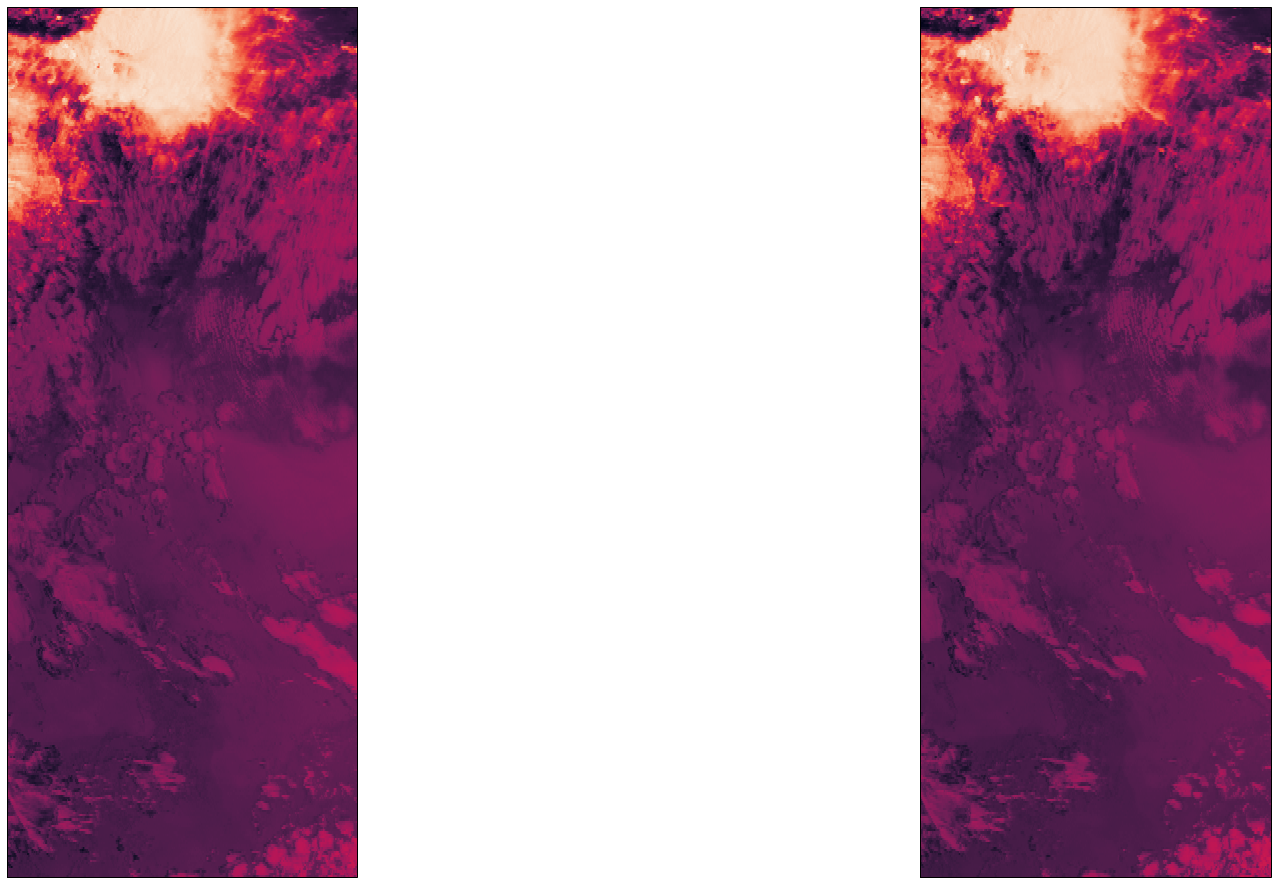

In [19]:
mc = ccrs.Mercator()
pc = ccrs.PlateCarree()
target_extent_mc_cartopy = trasform_cartopy_extent(ROI['extent'], pc, mc)
target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)


new_xr = xr.load_dataarray(op.join(outputPath, 'OR_ABI-L1b-RadF-M6C07_G16_s2019240_xr.nc'))
fig = plt.figure(figsize=(30, 16))
_,_,im_num = new_xr.data.shape
for i in range(1,im_num+1):
    ax_1 = fig.add_subplot(1, im_num, i, projection=mc)
    ax_1.set_extent(target_extent_mc_cartopy, crs=mc)
    ax_1.imshow(normIm(new_xr.data[:,:,i-1],gamma=1.0,reverse=True), origin='upper',
               extent=target_extent_mc_cartopy,
               transform=mc,
               interpolation='none')

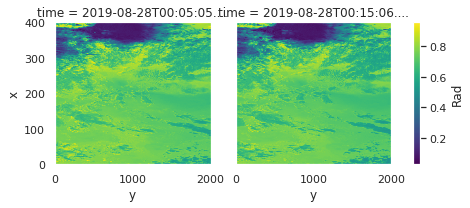

In [18]:
new_xr.plot(col='time')

In [ ]:
p = Path(DATAPATH,'OR_ABI-L1b-RadF-M6C07_G16_s2019240_xr.nc')

In [ ]:
p

In [ ]:
xr.load_dataset(p)

In [ ]:
import netCDF4

In [ ]:
xr.__version__